# University Related Coronavirus Sentiment Analysis
---

### Approach Description

We plan to start by harvesting tweets from Twitter accounts of two categories: UT Administration/Faculty/Staff and UT students/general population. The textual sentiment of these tweets will be calculated and compared during pre and post COVID-19 time periods, and we will compare the general attitudes of the tweets from these group's social media presence. Further comparison could include searching for correlation between sentiment and COVID-19 rates and other metrics. Also, comparison of this data between universities and looking at word frequencies could potentially lead to interesting findings. We will initially use a scraper to avoid Twitter's weak API for data gathering, and plan on using Jupyter Notebooks with numerous of the powerful data science libraries available for use in Python (NumPy, Pandas, Matplotlib, SciPy, TensorFlow, etc).

### Brief Outline

1. Cleaning
    - Tokenization
    - Normalization
    - Noise Removal
2. Modeling
    - Form training & testing datasets
    - Build & Test model
    - Use model to classify our Tweets
    - Visualizations & insights
3. VADER analysis
    - Visualizations & insights
4. Improvements & Looking Forward

## Tokenizing the Data
---

There are numerous ways we can "clean" our data to make our final predicitions better. First, we will do what is called "tokenizing."
This process will take the Tweets as a whole, and split it into smaller subsections called tokens. These tokens make it much
easier for machines to understand the context of the text when developing the model.

In [1]:
# import pandas as pd
# # Extract content and date fields from csv
# fields=['date', 'content']
# d = pd.read_csv('combined_csv.csv', usecols=fields)

import nltk
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Fortunately, NLTK contains another helpful resource known as ```punkt```. This is a pre-trained model that allows us to easily tokenize our data.

To get the ```punkt``` resrouce, we run the following command:

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/tucker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now we are able to utilize NLTK's powerful tokenization tools. We simply use the ```.tokenized()``` method in order to tokenize our data.

To demonstrate how this works, let's tokenize ```negative_tweets.json```

In [3]:
print('Not Tokenized:')
print(twitter_samples.strings('negative_tweets.json')[0])   # String
print()
print('Tokenized:')
print(twitter_samples.tokenized('negative_tweets.json')[0]) # The same string, tokenized

Not Tokenized:
hopeless for tmr :(

Tokenized:
['hopeless', 'for', 'tmr', ':(']


Let's go ahead and tokenize ```positive_tweets.json``` for later:

In [4]:
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
print(tweet_tokens[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


## Normalizing the Data
---

Normalization, in terms of natural language processing, is the process of transforming a text into a canonical (standard) form.
For example, "gooood," and "gud" can be resolved to the normalized form "good." This can also apply for different tenses of the same word. For example, "ran," "runs," and "running" are all forms of "run."

<br/>

#### There are a few things at work here:

Stemming is the process of removing suffixes and prefixes from words. As an example, it reduces the inflection in words such as "troubled" and "troubles" to their root form "trouble."

Here are some stemming examples made using Porters Algorithm, one of the most common stemming algorithms:

<html>
<img src="Documents/StemmingExample.PNG" alt="drawing" width="275"/>
</html>

Lemmatization is similar to stemming, but rather than just cutting off the affixes, it will transform the word to it's root. As an example, it may transform the word "better" to "good."

Here are some examples of lemmatization using a dictionary mapping for the translations:

<html>
<img src="Documents/LemmatizationExample.PNG" alt="drawing" width="275"/>
</html>

<br/>
<br/>


This processing is essential for noisy social-media posts, as abbreviations and mispellings are very common!

We will be using lemmatization for our data, so let's download ```wordnet```, a lexical database, and ```averaged_perceptron_tagger```, which will help us in determining context

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tucker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Before using the lemmatizer, we must determine the context of each word within our tweets. To do this, we use what's called a tagging algorithm. Fortunately, NLTK provides a function for this.

Let's test it here:

In [6]:
from nltk.tag import pos_tag
print(pos_tag(tweet_tokens[0]))

[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


Here are some common tags and their meaning:
- NNP: Noun, proper, singular
- NN: Noun, common, singular or mass
- IN: Preposition or conjunction, subordinating
- VBG: Verb, gerund or present participle
- VBN: Verb, past participle

Using the fact that tags starting with ``NN`` are typically nouns, and tags starting with ```VB``` are typically verbs, we can incorporate this into a function to lemmatize our data:

In [7]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

This function gets the position tag of each token in the tweet, and lemmatizes accordingly.
Let's test it here:

In [8]:
print(lemmatize_sentence(tweet_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


## Removing Noise from the Data
---

There is a lot of noise in tweets. Things such as hyperlinks, twitter handles, and some punctuation must be removed. That is what we will do here

To remove hyperlinks, we'll search for substrings ```http://``` and ```https://``` followed by the rest of the address. Once found, we will replace with an empty string.

In [9]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

This function removes noise and also incorporates the normalization and lemmatization as seen earlier. As arguments, it takes Tweet tokens and a stop words tuple.

Once again, NLTK is of great help here, as it provides a great stopwords set for us to use.

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/tucker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's briefly test this:

In [11]:
print(tweet_tokens[0])
print()
print(remove_noise(tweet_tokens[0], stop_words))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Now, we've removed all mentions, removed all stop words, and have made everything lowercase.

Next, let's go ahead and use this function to clean up the Tweets we saved earlier:

In [12]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [13]:
print(positive_tweet_tokens[0])
print()
print(positive_cleaned_tokens_list[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Much, much better! All of this processing will allow our model to be much more accurate!

## Word Density
---

One of the simplest forms of textual analysis is a simple word frequency. Let's take a look at the frequencies of words in some of these data sets.

In [14]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)

This is a generator function which will take a list of tokens as an argument and will provide a list of all of the words.

Now that we've combined all of the positive tweets, let's see what the most popular ones are. Once again, NLTK comes to the rescue!

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253), ('u', 245), ('day', 242), ('like', 229), ('see', 195), ('happy', 192)]


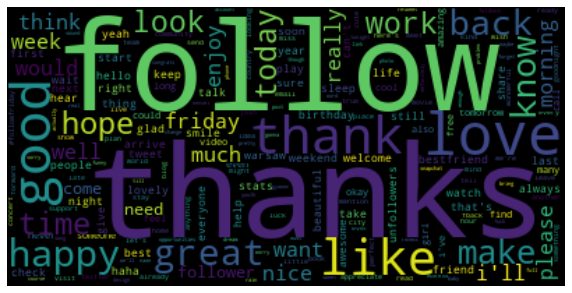

In [15]:
from nltk import FreqDist
from wordcloud import WordCloud
from matplotlib import pyplot as plt

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(15))


filter_words = dict([(m, n) for m, n in freq_dist_pos.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
# (-0.5, 399.5, 199.5, -0.5)
plt.show()

And now for the negatives:

[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218), ('♛', 210), ('》', 210), ('u', 193), ("can't", 180), ('time', 160)]


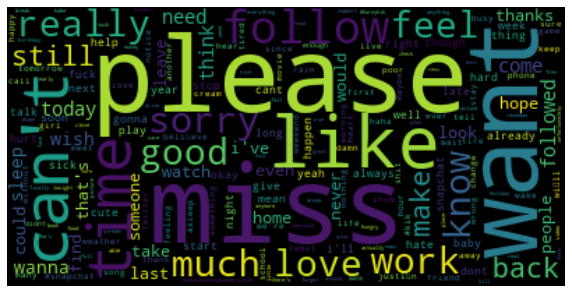

In [16]:
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(15))

filter_words = dict([(m, n) for m, n in freq_dist_neg.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
# (-0.5, 399.5, 199.5, -0.5)
plt.show()

Interesting. It's clear that emoticons are very common in both positive and negative Tweets. It's very interesting how you can begin to see some overall sentiment just from this frequency analysis, with the positive Tweets commonly having words such as "thanks," "love, " and "happy."

So, to summarize a bit, so far we have extracted tweets from NLTK, tokenized them, normalized them, and cleaned them up. Then, we looked at some basic frequency analysis. Let's move on to modeling!

## Prepping for Model
---

To make a model, we need to create a training set to train our model. This is known as supervised learning, the task of learning a function that maps an input to an output based on example input-output pairs. We must associate our datasets with a sentiment, and these is where our datasets of positive and negative datasets comes in. Here, we will train our model to classify into two categories, positive and negative. In order to do this, we will need to split our dataset into parts, one part for training the model and the another part for testing its accuracy.

We will be using the Naive Bayes Classifier in NLTK. If you've taken a statistics class, you've probably heard of Bayes' Thereom, and that is what this classifier is based on.

To use the Naive Bayes Classfier in NLTK, we must ocnvert our tokens to a dictionary with the words being the keys and the value being True.

Let's create a generator function which will convert the clean tokens to dictionaries with the words being the keys and the values all being True:

In [17]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

As mentioned earlier, we have to split our dataset. Part of it will be used for training, and the other for testing.

In [18]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

This attaches a sentiment to each tweet, and then combines them. To avoid bias, the combines dataset is shuffled.

After the above code runs, we have 10,000 Tweets to build our model. 7,000 will be used for training while the remaining 3,000 will be used for testing.

After all of this setup, we are finally to the point where we will build our model. We'll use some handy NLTK functions here: ```train()``` and ```accuracy```.

## Building and Testing our Model
---

In [19]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9956666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2069.5 : 1.0
                      :) = True           Positi : Negati =    978.2 : 1.0
                follower = True           Positi : Negati =     35.2 : 1.0
                     sad = True           Negati : Positi =     18.6 : 1.0
                     x15 = True           Negati : Positi =     17.9 : 1.0
                    glad = True           Positi : Negati =     17.4 : 1.0
                    blog = True           Positi : Negati =     14.2 : 1.0
                     idk = True           Negati : Positi =     13.2 : 1.0
                     ugh = True           Negati : Positi =     13.2 : 1.0
                 welcome = True           Positi : Negati =     11.7 : 1.0
None


The accuracy which was outputted above is the percentage of tweets that the model was correct. 99.7%, not too bad!

We also outputted the most informative features. This shows the ratio of that specific tokens occurence in the positive dataset to the negative dataset. Some more interesting insight into our data here!

Finally, we are to the point that we can pass our classifier a Tweet, and it will return it's sentiment. Let's Test it out!

We'll write our own example for a postive and negative tweet:

In [20]:
negative_tweet = 'Today was a terrible day! I spent forever trying to get my Jupyter Notebook to run properly, but it wouldn\'t budge! :('
positive_tweet = 'Today was amazing! I\'m very happy! :)'
                                                                                                                                        
from nltk.tokenize import word_tokenize

tokens = remove_noise(word_tokenize(negative_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))
                                                                                                                                        
tokens = remove_noise(word_tokenize(positive_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))

Negative
Positive


Working as intended!

With our model set up and working, let's move on to using it for something cool!

## Getting Our Data
---

As mentioned earlier, we are comparing two datasets. One dataset containing Tweets from accounts which are directly associated or owned by the University, and the other containing Tweets which are related to the university, but not directly associated or owned by the university.

For the tweets from accounts which are directly associated or owned by the University, we searched for Tweets from these accounts:

Administration:
- @DondePlowman - Donde Plowman
- @randyboyd - Randy Boyd
- @tucarpenter - Tiffany Carpenter
- @UTIA_SVP - Tim Cross
- @KC4UTM - Keith Carver

University Accounts:
- @utknoxville
- @utk_tce
- @utkdos
- @ut_admissions
- @utk_asc
- @UTKCEHHS
- @utk_cfs
- @UTKStudentLife
- @UTKCoAD
- @UTKSOM
- @tennalum
- @utknursing
- @HaslamUT

For the tweets from accounts which are not directly associated or owned by the University, we searched for Tweets with these keywords
- keyword1
- keyword2
- keyword3...

This data was colleced using the snscrape command line tool, and historically represent the time period of August 1st, 2019 to August 1st, 2020

## Analyzing Admininstration/University-Sanctioned Tweets
---

Now that we, have our data in CSVs, let's use Pandas to read them in:

In [21]:
import pandas as pd
# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df_1 = pd.DataFrame(data=d)
tweets_df_1

,date,content,user/username
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT
...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman


Let's use our model and add a column to our dataframe which represents the sentiment of each Tweet:

In [22]:
sentiment = []
tweets = tweets_df_1['content'].tolist()
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
tweets_df_1['sentiment'] = sentiment
tweets_df_1

,date,content,user/username,sentiment
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT,Positive
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT,Positive
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT,Positive
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT,Negative
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT,Positive
...,...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman,Negative
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman,Positive
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman,Positive
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman,Positive


Let's also take a quick look at the overall counts:

  Sentiment Count
0  Positive  5305
1  Negative  1738


<AxesSubplot:ylabel='Count'>

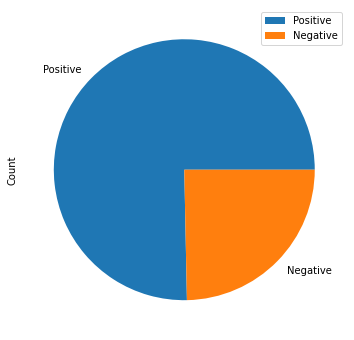

In [23]:
# tweets_df['sentiment'].value_counts()
proportions_df_1 = pd.DataFrame(tweets_df_1['sentiment'].value_counts().reset_index().values, columns=["Sentiment", "Count"])
print(proportions_df_1)
proportions_df_1.plot.pie(y='Count', labels=proportions_df_1['Sentiment'], figsize=(6,6))


Nice! Now we have associated a sentiment with each of these Tweets, as seen above!

Pandas doesn't like ISO 8601 time format, so let's use a lambda to change the dates to something readable by Pandas:

In [24]:
import dateutil.parser
# Convert ISO 8601 time format to be readable by pandas
tweets_df_1['date'] = tweets_df_1['date'].apply(lambda x: dateutil.parser.parse(x))

Let's use groupby to get the number of positive and negative Tweets for each week in our time period:

In [25]:
tweets_df_1['month/year'] = tweets_df_1['date'].apply(lambda x: "%d/%d" % (x.month, x.year))

# create column to sort off of
months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
mapping = {day: i for i, day in enumerate(months)}
tweets_df_1['sorter'] = tweets_df_1['month/year'].map(mapping)
tweets_df_1 = tweets_df_1.sort_values(by='sorter')

tweets_df_grouped_1 = tweets_df_1.groupby(['sorter', 'sentiment']).size()
tweets_df_grouped_1

sorter  sentiment
0       Negative     126
        Positive     434
1       Negative     150
        Positive     445
2       Negative     148
        Positive     465
3       Negative     129
        Positive     508
4       Negative     120
        Positive     300
5       Negative     119
        Positive     404
6       Negative     137
        Positive     365
7       Negative     223
        Positive     610
8       Negative     217
        Positive     486
9       Negative     121
        Positive     503
10      Negative     105
        Positive     350
11      Negative     109
        Positive     328
12      Negative      34
        Positive     107
dtype: int64

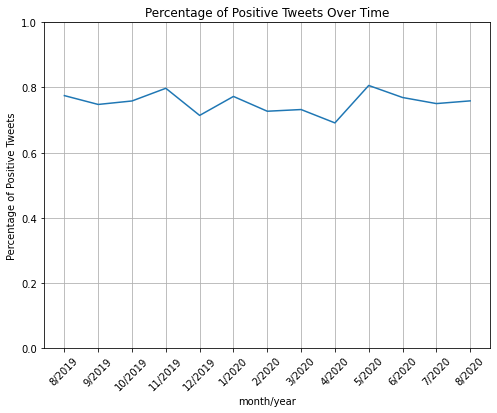

In [26]:
import numpy as np
from matplotlib import pyplot as plt

N = 2
count_tuples = [tweets_df_grouped_1.values[n:n+N] for n in range(0, len(tweets_df_grouped_1.values), N)]

pos_percentages_1 = []
for group in count_tuples:
#     print('{} divided by {}'.format(group[1], sum(group)))
    pos_percentages_1.append(group[1] / sum(group))

plt.figure(figsize=(8,6))
plt.plot(pos_percentages_1)
plt.xticks(np.arange(13), months, rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.show()

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020'),
 Text(12, 0, '8/2020')]

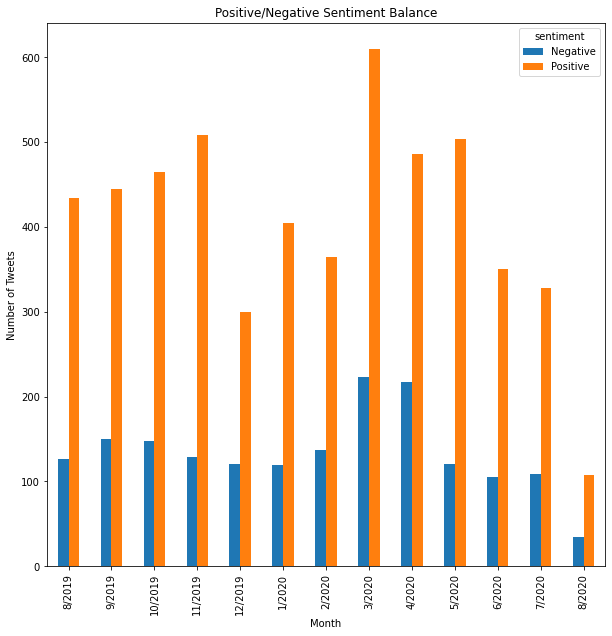

In [27]:
ax_1 = tweets_df_grouped_1.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(10, 10))
ax_1.set_xticklabels(months)

Interesting graphic here! There the ratio of positive to negative Tweets is very one sided in most months, leaning heavily on the positive side. Some interesting things to not here. In March, when things began closing down and switch up due to the pandemic, we see the highest number of positive Tweets out of all months! We propose this could be due to encouragement from campus leaders to stay strong when things were beginning to get rough, and to continue with the constant encouragement they tend to display. Also, we noticed a low level of negative Tweets in August, the beginning of the semester. However, the full month of August 2020 was not included in our collection process.

The two most heavily positive months were September 2019 and March 2020. Out of curiosity, and becasue of the fact that we 
really began to feel the pressure of the pandemic in march, let's take a closer look at that month specifically:

<ipython-input-28-8d6940726fcc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_1['day'] = daily_1['date'].apply(lambda x: "%d" % (x.day))
<ipython-input-28-8d6940726fcc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_1['day'] = daily_1['day'].astype(int)


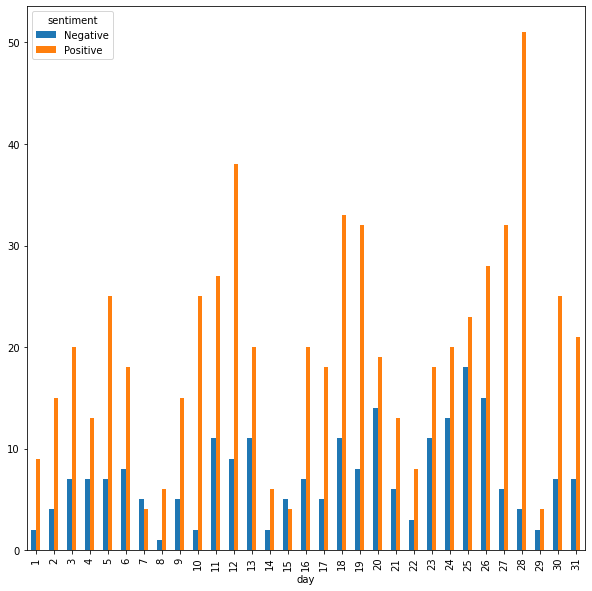

In [28]:
# Create boolean mask to filter out March
mask = (tweets_df_1['month/year'] == '3/2020')
# tweets_df[mask]

# W-MON weekly frequency (Mondays)
# weeks_march = tweets_df[mask].groupby('sentiment').resample('W-Mon', on='date').size().reset_index()
# weeks_march.T

# test = tweets_df[mask].groupby(['date', 'sentiment']).size()
# test

daily_1 = tweets_df_1[mask]
daily_1['day'] = daily_1['date'].apply(lambda x: "%d" % (x.day))
daily_1['day'] = daily_1['day'].astype(int)
daily_1 = daily_1.sort_values(by='day')
daily_1

test_grouped_1 = daily_1.groupby(['day', 'sentiment']).size()
# test_grouped = test_grouped.to_frame()
# test_grouped

daily_grouped_1 = test_grouped_1.unstack().plot.bar(figsize=(10, 10))

# tweets_df_grouped = tweets_df.groupby(['month/year', 'sentiment']).size()

# NOTE: Wed March 11 was initial extension of break. Monday March 16 was announcement of online through end of semester


---

Now, let's do the same thing with our datset of Tweets from non admin/uni Tweets:

The above analysis brings about some interesting discourse and gives us some nice visuals to analyze; however, there are a few drawbacks. The biggest of these drawbacks would be the fact that our model is a binary classifier, meaning it classifies the Tweets into only two categories, positive or negative. This can be misleading as neutral Tweets are common, and this approach forces the model to place one of these labels onto each Tweet.

However, there are more ways to analyze this, which we will get into now!

## Vader Sentiment Analysis
---

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a very powerful tool which will allow us to analyze our data in a much more specific manner. Even better, this tool is specifically adapted to sentiments which are expressed in social media.

This analysis is based on lexicons of sentiment-related words. A lexicon is taken, and each word is ranked not only as positive or negative, but how positive and negative it may be.

Here's an example of some words, and their associated sentiment ratings:

<html>
<img src="Documents/Vader Lexicon Excerpt.PNG" alt="drawing" width="700"/>
</html>


These words have been manually rated by humans, and if VADER's lexicon provides good coverage of the words in your data, it provides accurate, quick results.

Let's test it out:

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
    else : 
        print("Neutral") 

The above function takes the sentence argument, uses VADER to analyze it, and prints out the results

In [30]:
sentence = "Today was an amazing day! The weather was nice, and we all had a blast :)"
sentiment_scores(sentence)

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'compound': 0.8718}
sentence was rated as  0.0 % Negative
sentence was rated as  56.8 % Neutral
sentence was rated as  43.2 % Positive
Sentence Overall Rated As Positive


You can see that the text is given a rating for negative, neutral, and positive. The compound number is a representation of all 3. It is normalized to be between -1 and 1, the closer to -1 the more negative, the closer to 1 the more positive, and the closer to 0 the more neutral.

This will enable us to get a better look at the historic sentiment of our Tweets. Let's first analyze the Tweets of our admin/university sanctioned dataset. We'll set that up here:

In [31]:
# Extract content and date fields from csv
fields=['date', 'content']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df_1 = pd.DataFrame(data=d)

# Calculate polarity scores and store compound result into vals
sid_obj = SentimentIntensityAnalyzer() 

vals = []

tweets = tweets_df_1['content'].tolist()
for tweet in tweets:
    sentiment_dict = sid_obj.polarity_scores(tweet)
    vals.append(sentiment_dict['compound'])

# Add vals to dataframe
tweets_df_1['compound'] = vals 

# Concert ISO 8601 time format to be readable by pandas
tweets_df_1['date'] = tweets_df_1['date'].apply(lambda x: dateutil.parser.parse(x))

# Set index as the data
tweets_df_1.index = tweets_df_1['date']

# Drop content column and resample on a weekly basis, calculating the mean of each month
data_1 = tweets_df_1.drop(columns=['content']).resample('M').mean()

data_1.head()

,compound
date,
2019-08-31 00:00:00+00:00,0.457304
2019-09-30 00:00:00+00:00,0.465794
2019-10-31 00:00:00+00:00,0.450072
2019-11-30 00:00:00+00:00,0.553641
2019-12-31 00:00:00+00:00,0.394545


And just like that, we have grouped our Tweets by week and have calculated the VADER compound score on each chunk.

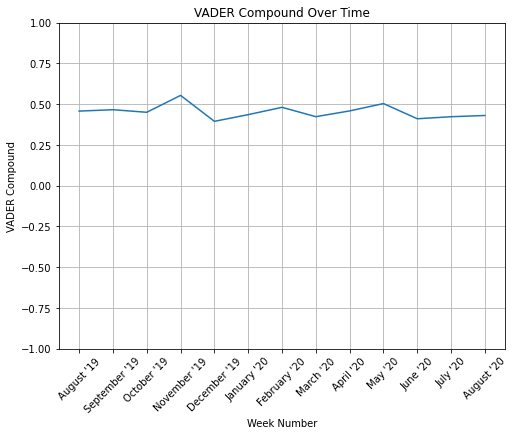

In [32]:
import matplotlib.pyplot as plt
import numpy as np

xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
          'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
          'July \'20', 'August \'20']


plt.figure(figsize=(8, 6))
plt.ylim(-1, 1)
plt.xticks(xticks, labels, rotation=45)
plt.grid()
# plt.plot(np.arange(1, 56), data)
plt.plot(np.arange(1, 14), data_1)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.show()

put more data insight here... Pretty stable month-to-month, with the lowest overall sentiment being in December 2019

## Analyzing Non Admininstration/University-Sanctioned Tweets
---

Now, let's look at the same visuals for our other dataset, and we'll start by calculating the sentiment for each Tweet:

In [33]:
import pandas as pd
# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combinedNonUniLessSkewed.csv', usecols=fields)

# Create dataframe
tweets_df_2 = pd.DataFrame(data=d)

sentiment = []
tweets = tweets_df_2['content'].tolist()
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
tweets_df_2['sentiment'] = sentiment

Then showing the proportions of positive to negative Tweets:

In [42]:
proportions_df_2 = pd.DataFrame(tweets_df_2['sentiment'].value_counts().reset_index().values, columns=["Sentiment", "Count"])
print(proportions_df_2)
proportions_df_2.plot.pie(y='Count', labels=proportions_df_2['Sentiment'], figsize=(6,6))

KeyError: 'sentiment'

Group them by month:

In [35]:
import dateutil.parser
# Convert ISO 8601 time format to be readable by pandas
tweets_df_2['date'] = tweets_df_2['date'].apply(lambda x: dateutil.parser.parse(x))

tweets_df_2['month/year'] = tweets_df_2['date'].apply(lambda x: "%d/%d" % (x.month, x.year))

# create column to sort off of
months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
mapping = {day: i for i, day in enumerate(months)}
tweets_df_2['sorter'] = tweets_df_2['month/year'].map(mapping)
tweets_df_2 = tweets_df_2.sort_values(by='sorter')

tweets_df_grouped_2 = tweets_df_2.groupby(['sorter', 'sentiment']).size()
tweets_df_grouped_2

sorter  sentiment
0.0     Negative      43
        Positive      59
1.0     Negative      87
        Positive      92
2.0     Negative      57
        Positive      81
3.0     Negative      72
        Positive      66
4.0     Negative      64
        Positive      79
5.0     Negative      84
        Positive     112
6.0     Negative     164
        Positive     247
7.0     Negative     286
        Positive     418
8.0     Negative     278
        Positive     390
9.0     Negative     358
        Positive     493
10.0    Negative     283
        Positive     374
11.0    Negative     240
        Positive     311
dtype: int64

Plot the percentage of positive Tweets over time:

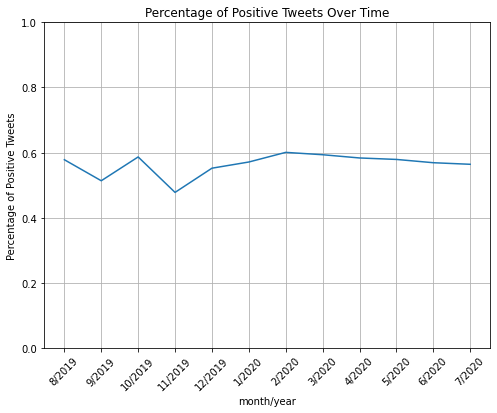

In [36]:
import numpy as np
from matplotlib import pyplot as plt

N = 2
count_tuples = [tweets_df_grouped_2.values[n:n+N] for n in range(0, len(tweets_df_grouped_2.values), N)]

pos_percentages_2 = []
for group in count_tuples:
#     print('{} divided by {}'.format(group[1], sum(group)))
    pos_percentages_2.append(group[1] / sum(group))

plt.figure(figsize=(8,6))
plt.plot(pos_percentages_2)
plt.xticks(np.arange(12), months[:-1], rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.show()

Plot the positive/negative balance for each month:

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020')]

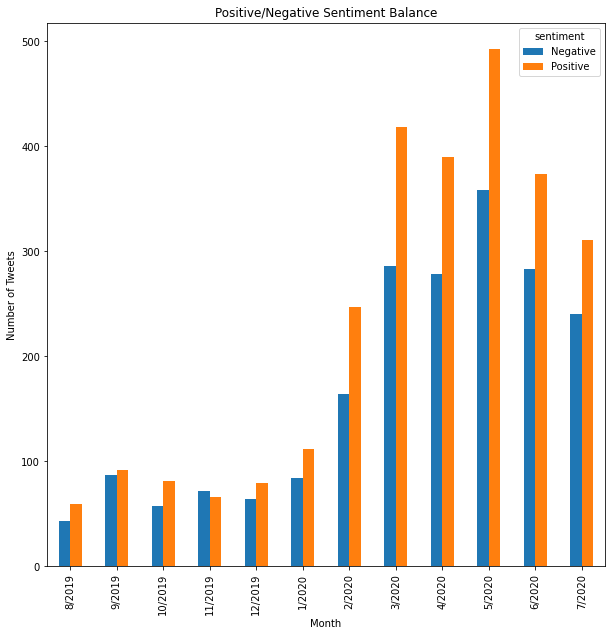

In [37]:
ax_2 = tweets_df_grouped_2.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(10, 10))
ax_2.set_xticklabels(months[:-1])

insightful passage here...

Talk about how we struggled with collecting good data for this section... and about how we had to switch scrapers

much harder to collect keyword based data rather than just selecting accounts from Tweets

Then run VADER:

In [38]:
import datetime

# Extract content and date fields from csv
fields=['date', 'content']
d = pd.read_csv('combinedNonUniLessSkewed.csv', usecols=fields)

# Create dataframe
tweets_df_2 = pd.DataFrame(data=d)

# Calculate polarity scores and store compound result into vals
sid_obj = SentimentIntensityAnalyzer() 

vals = []

tweets = tweets_df_2['content'].tolist()
for tweet in tweets:
    sentiment_dict = sid_obj.polarity_scores(tweet)
    vals.append(sentiment_dict['compound'])

# Add vals to dataframe
tweets_df_2['compound'] = vals 

# Concert ISO 8601 time format to be readable by pandas
tweets_df_2['date'] = tweets_df_2['date'].apply(lambda x: dateutil.parser.parse(x))

# Set index as the data
tweets_df_2.index = tweets_df_2['date']

tweets_df_2 = tweets_df_2[tweets_df_2['date'] < '2020-09-01 00:00:00+00:00']

# Drop content column and resample on a weekly basis, calculating the mean of each month
data_2 = tweets_df_2.drop(columns=['content']).resample('M').mean()

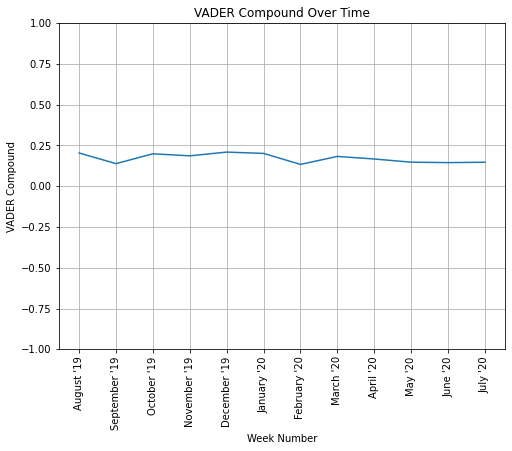

In [39]:
import matplotlib.pyplot as plt
import numpy as np

xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
          'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
          'July \'20', 'August \'20']


plt.figure(figsize=(8, 6))
plt.ylim(-1, 1)
plt.xticks(xticks, labels, rotation=90)
plt.grid()
# plt.plot(np.arange(1, 56), data)
plt.plot(np.arange(1, 13), data_2)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.show()

## Comparison

---

To see if we can gain any more insight from our data, let's compare plot some of the data together and compare the visuals:

In [40]:
proportions_df1

NameError: name 'proportions_df1' is not defined

In [41]:
proportions_df2

NameError: name 'proportions_df2' is not defined

In [43]:
pos_percentages_1

[0.775,
 0.7478991596638656,
 0.7585644371941273,
 0.7974882260596546,
 0.7142857142857143,
 0.7724665391969407,
 0.7270916334661355,
 0.7322929171668667,
 0.6913229018492176,
 0.8060897435897436,
 0.7692307692307693,
 0.7505720823798627,
 0.7588652482269503]

In [47]:
tweets_df_grouped_1

sorter  sentiment
0       Negative     126
        Positive     434
1       Negative     150
        Positive     445
2       Negative     148
        Positive     465
3       Negative     129
        Positive     508
4       Negative     120
        Positive     300
5       Negative     119
        Positive     404
6       Negative     137
        Positive     365
7       Negative     223
        Positive     610
8       Negative     217
        Positive     486
9       Negative     121
        Positive     503
10      Negative     105
        Positive     350
11      Negative     109
        Positive     328
12      Negative      34
        Positive     107
dtype: int64

In [48]:
tweets_df_grouped_2

sorter  sentiment
0.0     Negative      43
        Positive      59
1.0     Negative      87
        Positive      92
2.0     Negative      57
        Positive      81
3.0     Negative      72
        Positive      66
4.0     Negative      64
        Positive      79
5.0     Negative      84
        Positive     112
6.0     Negative     164
        Positive     247
7.0     Negative     286
        Positive     418
8.0     Negative     278
        Positive     390
9.0     Negative     358
        Positive     493
10.0    Negative     283
        Positive     374
11.0    Negative     240
        Positive     311
dtype: int64

In [44]:
pos_percentages_2

[0.5784313725490197,
 0.5139664804469274,
 0.5869565217391305,
 0.4782608695652174,
 0.5524475524475524,
 0.5714285714285714,
 0.6009732360097324,
 0.59375,
 0.5838323353293413,
 0.5793184488836662,
 0.5692541856925418,
 0.5644283121597096]

In [45]:
data_1

,compound
date,
2019-08-31 00:00:00+00:00,0.457304
2019-09-30 00:00:00+00:00,0.465794
2019-10-31 00:00:00+00:00,0.450072
2019-11-30 00:00:00+00:00,0.553641
2019-12-31 00:00:00+00:00,0.394545
2020-01-31 00:00:00+00:00,0.435599
2020-02-29 00:00:00+00:00,0.480479
2020-03-31 00:00:00+00:00,0.423068
2020-04-30 00:00:00+00:00,0.458488


In [46]:
data_2

,compound
date,
2019-08-31 00:00:00+00:00,0.203762
2019-09-30 00:00:00+00:00,0.138416
2019-10-31 00:00:00+00:00,0.198922
2019-11-30 00:00:00+00:00,0.186326
2019-12-31 00:00:00+00:00,0.209317
2020-01-31 00:00:00+00:00,0.201177
2020-02-29 00:00:00+00:00,0.133866
2020-03-31 00:00:00+00:00,0.182743
2020-04-30 00:00:00+00:00,0.166931
